# Darcy Flow with Triangular Notch

Mapping: $a(x,y) \to u(x,y)$ where $u$ satisfies
$$-\nabla\cdot\bigl(a(x,y)\,\nabla u(x,y)\bigr) = f(x,y), \quad (x,y)\in\Omega\subset[0,1]^2,$$
with Dirichlet boundary $u|_{\partial\Omega}=0$.

The domain contains a **triangular notch** that modifies the boundary geometry.

**Data**: a single `.mat` file with fields `boundCoeff` (boundary coefficient) and `sol` (solution).

In [1]:
import sys, os
sys.path.insert(0, os.path.join(os.getcwd(), '..'))

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.patches import Rectangle
from IPython.display import HTML
from sgpo.data.readers import MatReader

plt.rcParams.update({'figure.dpi': 120, 'font.size': 11, 'axes.titlesize': 13})

DATA_PATH = '/DATA/Sawan_projects/research/DATA/Darcy_Triangular_FNO.mat'
SUB = 3
S = 34
NTRAIN = 1500
NTEST = 100

In [2]:
def mask_triangular_notch(ax):
    """Mask regions outside the triangular notch domain with white overlays.
    
    The domain is a triangle with vertices at (0,0), (1,0), (0.5, ymax)
    plus a narrow rectangular notch at center. We mask everything outside
    this triangle by filling the upper-left and upper-right corners, the
    strip above ymax, and adding the center notch line.
    """
    xmax = 1.0
    ymax = 1.0 - 8 / 51  # ~0.843

    # Left triangular mask (upper-left corner)
    xf = np.array([0., xmax / 2])
    yf = xf * (ymax / (xmax / 2))
    ax.fill_between(xf, yf, ymax, color='white')

    # Right triangular mask (upper-right corner)
    xf = np.array([xmax / 2, xmax])
    yf = (xf - xmax) * (ymax / ((xmax / 2) - xmax))
    ax.fill_between(xf, yf, ymax, color='white')

    # Strip above ymax (top band)
    xf = np.array([0, xmax])
    ax.fill_between(xf, ymax, 1.0, color='white')

    # Center notch line
    ax.add_patch(Rectangle((0.5, 0), 0.01, 0.41, facecolor='white'))

In [3]:
reader = MatReader(DATA_PATH)
boundCoeff_all = reader.read_field('boundCoeff').numpy()[:, ::SUB, ::SUB][:, :S, :S]
sol_all = reader.read_field('sol').numpy()[:, ::SUB, ::SUB][:, :S, :S]

boundCoeff_tr = boundCoeff_all[:NTRAIN]
sol_tr = sol_all[:NTRAIN]
boundCoeff_te = boundCoeff_all[-NTEST:]
sol_te = sol_all[-NTEST:]

print(f'Full dataset \u2013 boundCoeff: {boundCoeff_all.shape}, sol: {sol_all.shape}')
print(f'Train \u2013 boundCoeff: {boundCoeff_tr.shape}, sol: {sol_tr.shape}')
print(f'Test  \u2013 boundCoeff: {boundCoeff_te.shape}, sol: {sol_te.shape}')
print(f'boundCoeff range: [{boundCoeff_tr.min():.4f}, {boundCoeff_tr.max():.4f}]')
print(f'sol range:        [{sol_tr.min():.4f}, {sol_tr.max():.4f}]')

Full dataset – boundCoeff: (2000, 34, 34), sol: (2000, 34, 34)
Train – boundCoeff: (1500, 34, 34), sol: (1500, 34, 34)
Test  – boundCoeff: (100, 34, 34), sol: (100, 34, 34)
boundCoeff range: [-4.4222, 3.3575]
sol range:        [-4.4282, 3.3583]


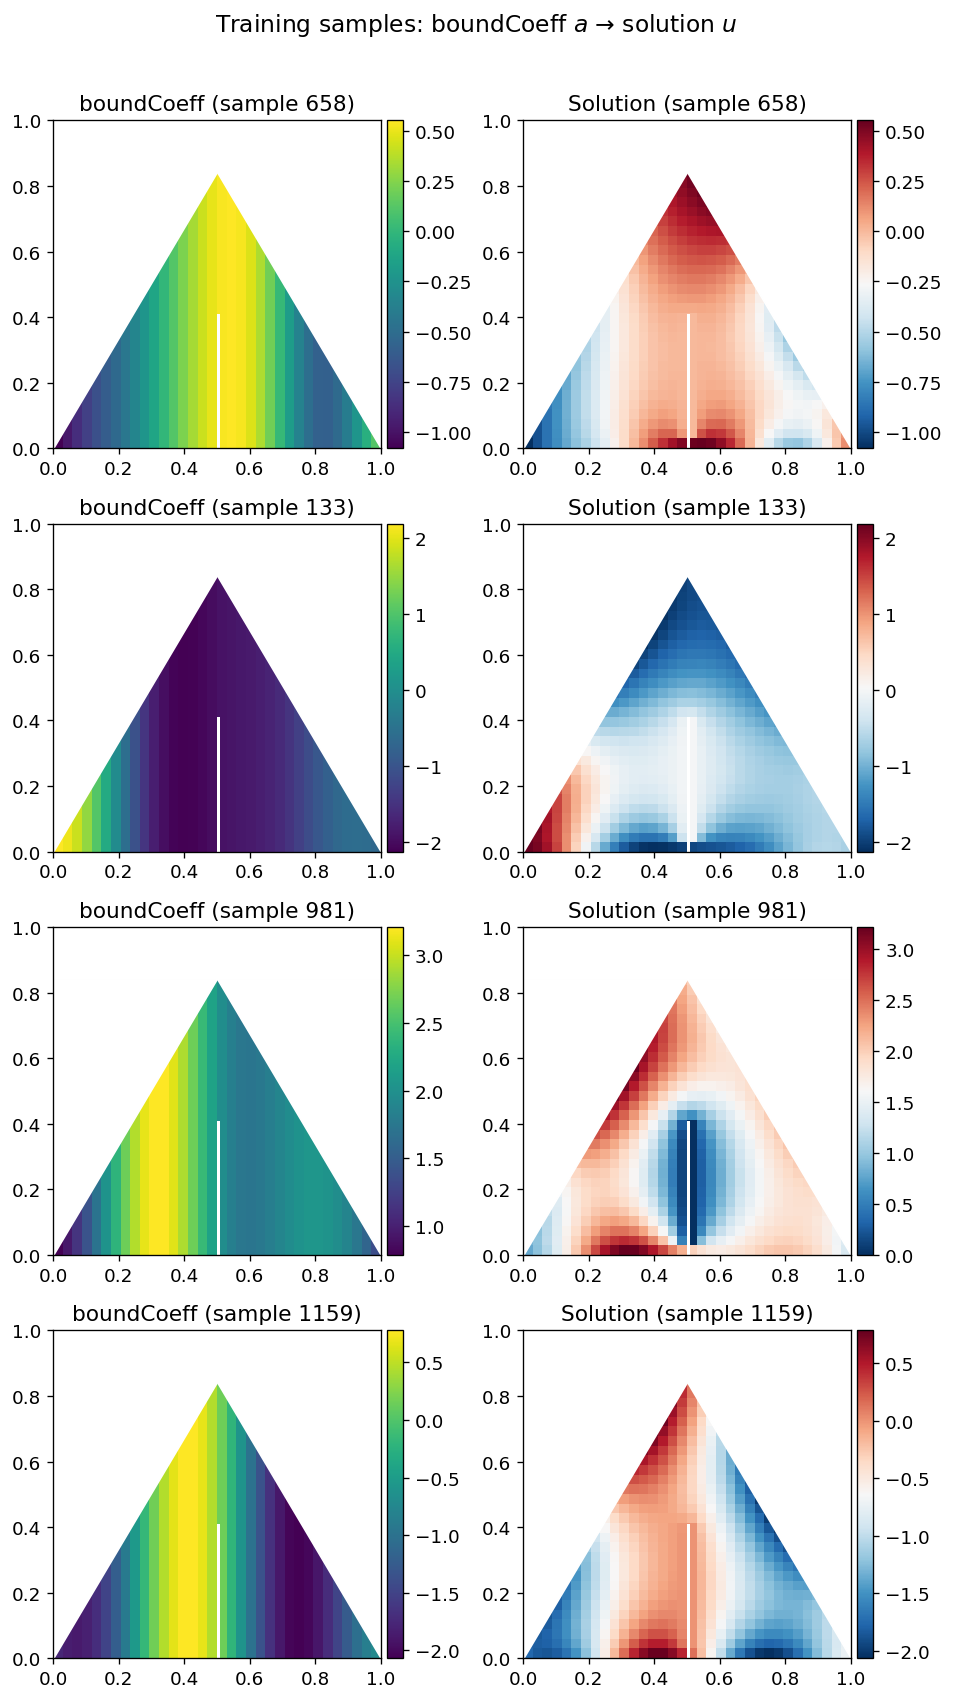

In [4]:
def plot_contour_pair(bc, sol, idx, axes):
    """Plot a single boundCoeff/sol pair as filled contours with triangular mask."""
    for arr, ax, title, cmap in [
        (bc[idx], axes[0], f'boundCoeff (sample {idx})', 'viridis'),
        (sol[idx], axes[1], f'Solution (sample {idx})', 'RdBu_r'),
    ]:
        im = ax.imshow(arr, cmap=cmap, origin='lower', extent=[0, 1, 0, 1])
        ax.set_title(title)
        mask_triangular_notch(ax)
        divider = make_axes_locatable(ax)
        plt.colorbar(im, cax=divider.append_axes('right', size='5%', pad=0.05))

rng = np.random.default_rng(42)
idxs = rng.choice(boundCoeff_tr.shape[0], 4, replace=False)

fig, axes = plt.subplots(4, 2, figsize=(8, 14))
for row, idx in enumerate(idxs):
    plot_contour_pair(boundCoeff_tr, sol_tr, idx, axes[row])
fig.suptitle('Training samples: boundCoeff $a$ \u2192 solution $u$', fontsize=14, y=1.01)
fig.tight_layout()
plt.show()

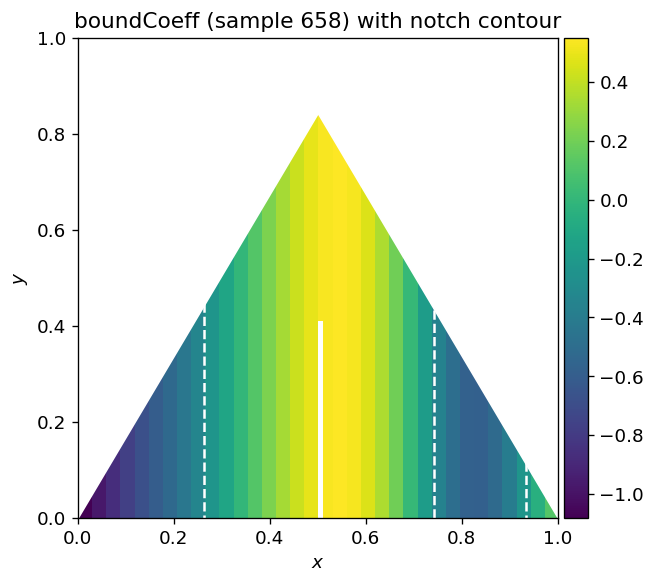

In [5]:
sample_idx = idxs[0]
bc_sample = boundCoeff_tr[sample_idx]

fig, ax = plt.subplots(figsize=(6, 5))
im = ax.imshow(bc_sample, cmap='viridis', origin='lower', extent=[0, 1, 0, 1])
divider = make_axes_locatable(ax)
plt.colorbar(im, cax=divider.append_axes('right', size='5%', pad=0.05))

# Overlay contour to highlight the triangular notch boundary
level = 0.5 * (bc_sample.min() + bc_sample.max())
xs = np.linspace(0, 1, bc_sample.shape[1])
ys = np.linspace(0, 1, bc_sample.shape[0])
ax.contour(xs, ys, bc_sample, levels=[level], colors='white', linewidths=1.5)

# Mask regions outside the triangular domain
mask_triangular_notch(ax)

ax.set_title(f'boundCoeff (sample {sample_idx}) with notch contour')
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
fig.tight_layout()
plt.show()

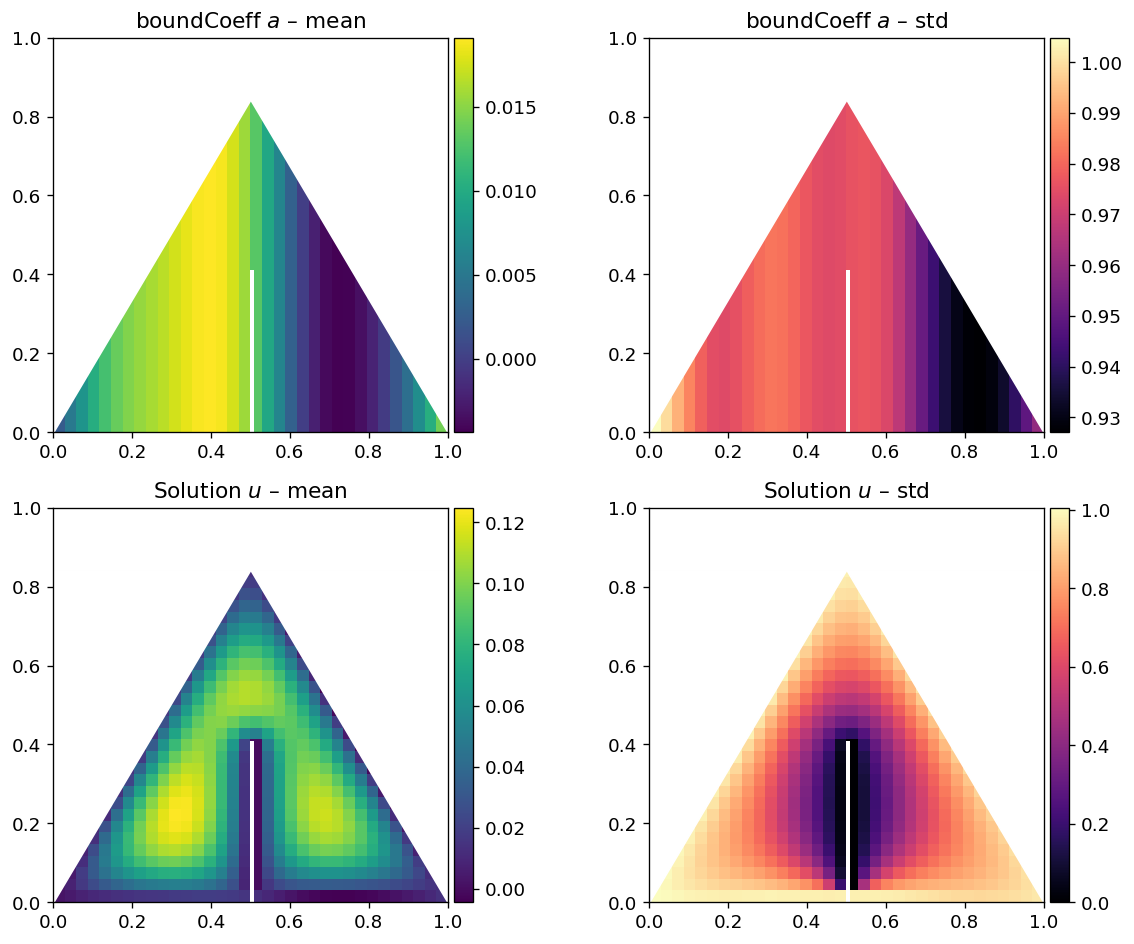

In [6]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
for row, (arr, name) in enumerate([(boundCoeff_tr, 'boundCoeff $a$'), (sol_tr, 'Solution $u$')]):
    mu = arr.mean(axis=0)
    sd = arr.std(axis=0)
    for col, (field, label, cmap) in enumerate([
        (mu, f'{name} \u2013 mean', 'viridis'),
        (sd, f'{name} \u2013 std', 'magma'),
    ]):
        im = axes[row, col].imshow(field, cmap=cmap, origin='lower', extent=[0, 1, 0, 1])
        axes[row, col].set_title(label)
        mask_triangular_notch(axes[row, col])
        divider = make_axes_locatable(axes[row, col])
        plt.colorbar(im, cax=divider.append_axes('right', size='5%', pad=0.05))
fig.tight_layout()
plt.show()

## Value Distributions

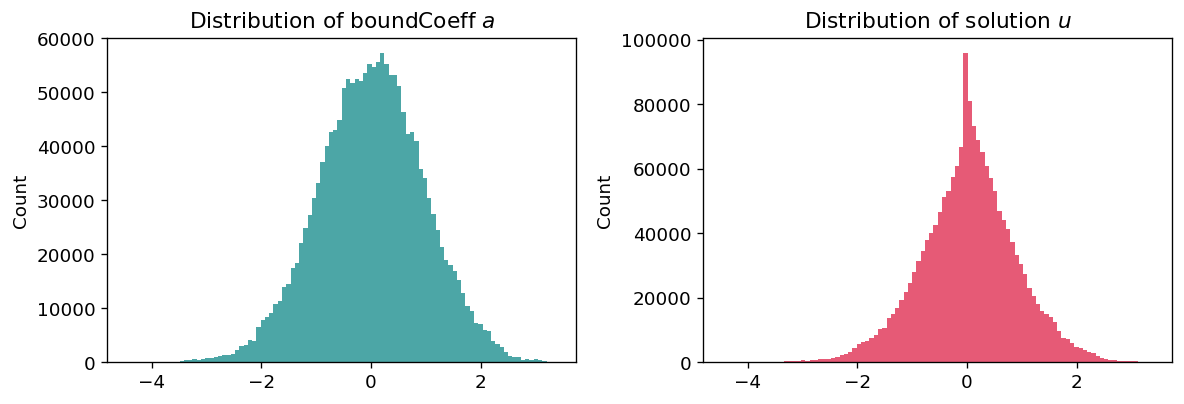

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(10, 3.5))
axes[0].hist(boundCoeff_tr.ravel(), bins=100, color='teal', alpha=0.7)
axes[0].set_title('Distribution of boundCoeff $a$')
axes[0].set_ylabel('Count')
axes[1].hist(sol_tr.ravel(), bins=100, color='crimson', alpha=0.7)
axes[1].set_title('Distribution of solution $u$')
axes[1].set_ylabel('Count')
fig.tight_layout()
plt.show()

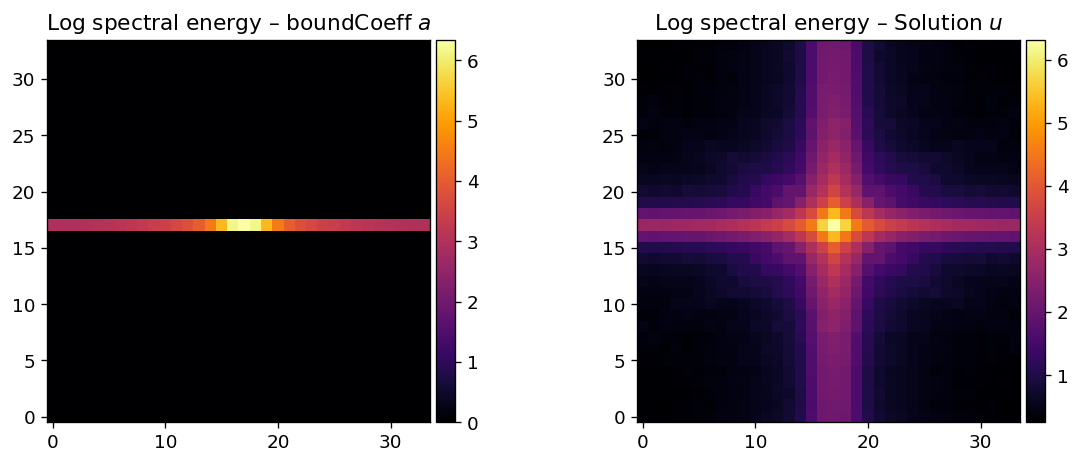

In [8]:
bc_fft = np.abs(np.fft.fft2(boundCoeff_tr)).mean(axis=0)
sol_fft = np.abs(np.fft.fft2(sol_tr)).mean(axis=0)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
for arr, ax, title in [(bc_fft, axes[0], 'boundCoeff $a$'), (sol_fft, axes[1], 'Solution $u$')]:
    shifted = np.fft.fftshift(np.log1p(arr))
    im = ax.imshow(shifted, cmap='inferno', origin='lower')
    ax.set_title(f'Log spectral energy \u2013 {title}')
    divider = make_axes_locatable(ax)
    plt.colorbar(im, cax=divider.append_axes('right', size='5%', pad=0.05))
fig.tight_layout()
plt.show()

# Apply triangular domain mask to both axes


In [9]:
n_anim = 40
anim_idxs = rng.choice(boundCoeff_tr.shape[0], n_anim, replace=False)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4))
im1 = ax1.imshow(boundCoeff_tr[anim_idxs[0]], cmap='viridis', origin='lower', extent=[0, 1, 0, 1])
im2 = ax2.imshow(sol_tr[anim_idxs[0]], cmap='RdBu_r', origin='lower', extent=[0, 1, 0, 1])
ax1.set_title('boundCoeff $a$')
ax2.set_title('Solution $u$')
plt.colorbar(im1, ax=ax1, fraction=0.046)
plt.colorbar(im2, ax=ax2, fraction=0.046)
title = fig.suptitle(f'Sample {anim_idxs[0]}')

# Apply triangular domain mask to both axes
mask_triangular_notch(ax1)
mask_triangular_notch(ax2)

vmin_bc, vmax_bc = boundCoeff_tr.min(), boundCoeff_tr.max()
vmin_sol, vmax_sol = sol_tr.min(), sol_tr.max()
im1.set_clim(vmin_bc, vmax_bc)
im2.set_clim(vmin_sol, vmax_sol)

def _update(frame):
    idx = anim_idxs[frame]
    im1.set_data(boundCoeff_tr[idx])
    im2.set_data(sol_tr[idx])
    title.set_text(f'Sample {idx}')
    return im1, im2, title

ani = animation.FuncAnimation(fig, _update, frames=n_anim, interval=350, blit=True)
plt.close(fig)
HTML(ani.to_jshtml())